In [231]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lars_path

%matplotlib inline
sns.set()

In [232]:
with open('../feature_engineering/video_channel_df_8162_fin.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [233]:
df.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc', 'channel_URL', 'channel_name'],
      dtype='object')

In [234]:
X_array = df.loc[:,'video_order_num':'sentiment_score_video_desc'].values.reshape(-1, 1)
X_df = df[['video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc']]
y = df['views_video']

## Baseline linear regression

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, 
                                                    test_size=0.3, 
                                                    random_state=22)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
#                                                  y_train_val, 
#                                                  test_size=.2, 
#                                                  random_state=43)
vanilla_LR = LinearRegression()
vanilla_LR.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [268]:
vanilla_LR.score(X_train,y_train) 

0.9670668620423999

In [269]:
vanilla_LR.score(X_test,y_test)

0.9106869228278733

## Remove outliers

In [252]:
df['res'] = abs(vanilla_LR.predict(X_df)-df['views_video'])

In [253]:
df['res'].describe()

count    8.162000e+03
mean     1.787641e+05
std      1.405329e+06
min      9.979857e+00
25%      3.094680e+04
50%      6.508526e+04
75%      1.173004e+05
max      9.533143e+07
Name: res, dtype: float64

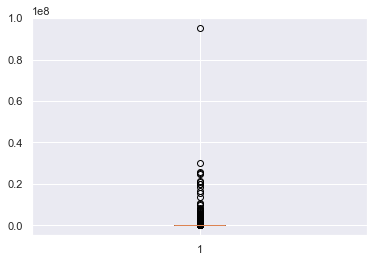

In [254]:
plt.boxplot(df['res']);

In [255]:
#outliers in terms of residuals
df[df['res'] > 1.233987e+07]

,views_video,video_order_num,duration_sec,likes,dislikes,video_desc_length,subscriber_count,total_views_channel,n_featured_channels,n_promo_links,channel_desc_length,channel_age_days,video_age_days,delivery_method_Published,delivery_method_Streamed live,sentiment_score_channel_desc,sentiment_score_video_desc,channel_URL,channel_name,res
video_id,,,,,,,,,,,,,,,,,,,,
8uAz-0ADqd4,52743498.0,30.0,52.0,28300.0,1373.0,1036.0,670000.0,59473573.0,2.0,4.0,721.0,3462.0,3060.0,1,0,22.0,18.0,https://www.youtube.com/user/shilpayoga,Shilpa Shetty Kundra,2.149663e+07
46ND9G6sGNw,15212610.0,23.0,399.0,991.0,34.0,187.0,0.0,182645.0,0.0,3.0,197.0,4788.0,3857.0,1,0,2.0,12.0,https://www.youtube.com/user/stephkittell,WEBSITE,1.387112e+07
KpGv0tmP4E8,40390416.0,8.0,295.0,4387.0,1448.0,358.0,32300.0,7815228.0,0.0,6.0,791.0,2772.0,2456.0,1,0,9.0,9.0,https://www.youtube.com/user/zaoyoga,ZaoYoga,1.981261e+07
6j4jm8Xf86U,4431841.0,23.0,273.0,21910.0,1572.0,764.0,90200.0,14038606.0,0.0,0.0,17.0,2969.0,460.0,0,0,0.0,5.0,https://www.youtube.com/channel/UCA04EYY6ZDiLW...,,2.572987e+07
oqCqPnMtQ1I,15847556.0,12.0,385.0,43.0,1.0,90.0,5780.0,1642065.0,0.0,0.0,0.0,2443.0,2443.0,1,0,0.0,0.0,https://www.youtube.com/channel/UC0bvNaJz9MPNW...,,1.556471e+07
sXSzAeOADbE,30871111.0,23.0,1500.0,15905.0,166.0,3074.0,101000.0,2327723.0,0.0,2.0,963.0,649.0,344.0,1,0,-2.0,-5.0,https://www.youtube.com/channel/UCod2Gi9j8THW1...,Fotos e Dicas de Yoga!,2.109141e+07
cNn2svpM_mU,18497011.0,2.0,60.0,1315.0,91.0,73.0,1740.0,245968.0,0.0,0.0,120.0,1206.0,353.0,1,0,1.0,0.0,https://www.youtube.com/channel/UCOsPqobaY6odj...,,1.671359e+07
TQr6c07N5cE,34892210.0,1.0,251.0,4711.0,222.0,1446.0,0.0,29174939.0,0.0,0.0,261.0,644.0,328.0,0,0,0.0,-3.0,https://www.youtube.com/channel/UC4dlco6FzS-AJ...,,3.004103e+07
2Z3DC7RLjfY,265463661.0,2.0,200.0,165045.0,7101.0,2979.0,0.0,29174939.0,0.0,0.0,261.0,644.0,381.0,1,0,0.0,9.0,https://www.youtube.com/channel/UC4dlco6FzS-AJ...,,9.533143e+07


In [256]:
df_no_outliers = df[df['res'] < 1.233987e+07]  ## keep 6

In [257]:
df_no_outliers.shape ##removed 181 observations with greatest residual values 

(8149, 20)

In [258]:
X_array_no_outliers = df_no_outliers.loc[:,'video_order_num':'sentiment_score_video_desc'].values.reshape(-1, 1)
X_df_no_outliers = df_no_outliers[['video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc']]
y_no_outliers = df_no_outliers['views_video']

## Baseline Regression with Outliers Removed

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X_df_no_outliers, 
                                                    y_no_outliers, 
                                                    test_size=0.3, 
                                                    random_state=22)

In [261]:
vanilla_LR_no = LinearRegression()
vanilla_LR_no.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [262]:
vanilla_LR_no.score(X_train,y_train) #--> outliers

0.9564159087694497

In [263]:
vanilla_LR_no.score(X_test,y_test)

0.9938225771189522

## Regularizing, keeping Original Features

In [94]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray

In [95]:
alphavec = 10**np.linspace(-6,4,200)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train);

In [96]:
lasso_model.score(X_tr,y_train)

0.9020243619504923

In [97]:
lasso_model.alpha_

1e-06

In [98]:
lasso_model.score(X_te,y_test) ##doesnt work

0.9790659767868077

## New Features Engineering

Polynomial

In [99]:
pf = PolynomialFeatures(degree=2)

In [102]:
orig_features = X_df_no_outliers.columns
pf.fit(df_no_outliers[orig_features])

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [103]:
feat_array = pf.transform(df_no_outliers[orig_features])
#feat_array = pd.DataFrame(feat_array, columns = pf.get_feature_names(input_features=orig_features))

In [104]:
#y = df_no_outliers['views_video']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(feat_array, y_no_outliers, test_size=0.33, random_state=42)
model_w_poly_feat = LinearRegression()
model_w_poly_feat.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [106]:
model_w_poly_feat.score(X_train,y_train)

0.9439757068163651

In [107]:
model_w_poly_feat.score(X_test,y_test)

0.9533797286449197

In [110]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray
alphavec = 10**np.linspace(-2,7,200)
lasso_model_w_poly_feat = LassoCV(alphas = alphavec, cv=5)
lasso_model_w_poly_feat.fit(X_tr, y_train);

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1553897784257.625, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1531415718627.25, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1094672767132.0, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarn

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83121495414336.19, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92401780203773.5, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100604717980847.47, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172305942633652.53, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173182041941343.9, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173982567528419.56, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182444320832381.72, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182539547216987.47, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182629862531546.94, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5428573273121.4375, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9611921025748.656, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13057953740831.438, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96564635681266.25, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98839224856676.4, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100942903009809.0, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130107921942324.94, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130715428774290.4, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131281981666086.77, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15462018783769.625, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21461061624140.375, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27284040372292.75, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145463512201011.22, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147373784054114.9, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149122593764075.12, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169318652912584.28, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169480213335831.5, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169627277869185.94, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3541723892010.625, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3570046965688.6875, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3631563424535.5, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88278804303377.12, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91296100739007.1, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94040144405018.92, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121347856311002.2, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121498750250613.53, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121635193271771.47, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 435408478940.5, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598142482273.0, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 822186479903.625, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning:

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34683954764466.344, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38526576507840.69, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43110891770233.81, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergence

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114244922486197.06, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114922607892799.77, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115525838629306.52, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124722051309896.12, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124803623989042.27, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124886272593899.45, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

In [111]:
lasso_model_w_poly_feat.score(X_tr,y_train)

0.9400812614533199

In [112]:
lasso_model_w_poly_feat.alpha_

11489.510001873086

In [113]:
lasso_model_w_poly_feat.score(X_te,y_test)

0.9092048487301712

## Channel Level Aggrigative Features

In [114]:
df_no_outliers.head()

,views_video,video_order_num,duration_sec,likes,dislikes,video_desc_length,subscriber_count,total_views_channel,n_featured_channels,n_promo_links,channel_desc_length,channel_age_days,video_age_days,delivery_method_Published,delivery_method_Streamed live,sentiment_score_channel_desc,sentiment_score_video_desc,channel_URL,channel_name,res
video_id,,,,,,,,,,,,,,,,,,,,
3GYdWbDE_0g,932.0,1.0,349.0,10.0,0.0,1008.0,3070.0,237924.0,0.0,2.0,288.0,4426.0,2.0,1,0,11.0,15.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,51718.111591
nCKcW9wbMlM,20461.0,15.0,60.0,12.0,0.0,381.0,3070.0,237924.0,0.0,2.0,288.0,4426.0,644.0,1,0,11.0,5.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,833.183562
KMGAlkw-MbA,1602.0,17.0,159.0,5.0,0.0,1120.0,3070.0,237924.0,0.0,2.0,288.0,4426.0,824.0,1,0,11.0,34.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,36496.175352
HHudryLLmbk,2312.0,16.0,60.0,6.0,0.0,1193.0,3070.0,237924.0,0.0,2.0,288.0,4426.0,819.0,1,0,11.0,12.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,66229.917724
AdoqTzZwljk,8392.0,19.0,60.0,8.0,0.0,529.0,3070.0,237924.0,0.0,2.0,288.0,4426.0,906.0,1,0,11.0,8.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,21721.240350


In [115]:
df_no_outliers.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc', 'channel_URL', 'channel_name', 'res'],
      dtype='object')

In [116]:
df_channel_video_history = (df_no_outliers
 .groupby(['channel_URL'])[['views_video', 'video_order_num', 'video_desc_length', 
                            'likes', 'dislikes', 'duration_sec', 
                            'video_age_days', 'sentiment_score_video_desc']]
 .agg({
     'views_video':'mean',
     'video_order_num':'count',
     'video_desc_length': 'mean',
     'likes':'sum',
     'dislikes':'sum',
     'duration_sec':'mean',
     'video_age_days':'mean',
     'sentiment_score_video_desc':'mean'
     
 })
)

In [117]:
df_no_outliers_history = df_no_outliers.join(df_channel_video_history, on='channel_URL', how='left', rsuffix='_history')

In [118]:
df_no_outliers_history.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc', 'channel_URL', 'channel_name', 'res',
       'views_video_history', 'video_order_num_history',
       'video_desc_length_history', 'likes_history', 'dislikes_history',
       'duration_sec_history', 'video_age_days_history',
       'sentiment_score_video_desc_history'],
      dtype='object')

### Polynomial Features on Enriched Dataset

In [119]:
X_array_no_outliers_h = df_no_outliers_history.loc[:,'video_order_num':'sentiment_score_video_desc_history'].values.reshape(-1, 1)
X_df_no_outliers_h = df_no_outliers_history[['video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc', 'channel_URL', 'channel_name', 'res',
       'views_video_history', 'video_order_num_history',
       'video_desc_length_history', 'likes_history', 'dislikes_history',
       'duration_sec_history', 'video_age_days_history',
       'sentiment_score_video_desc_history']]
y_no_outliers_h = df_no_outliers_history['views_video']

In [120]:
pf = PolynomialFeatures(degree=2)
orig_features_h = X_df_no_outliers.columns
pf.fit(df_no_outliers_history[orig_features_h])

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [121]:
feat_array_h = pf.transform(df_no_outliers_history[orig_features_h])
feat_array_h = pd.DataFrame(feat_array_h, columns = pf.get_feature_names(input_features=orig_features_h))

In [353]:
#y = df_no_outliers['views_video']

In [122]:
X_train, X_test, y_train, y_test = train_test_split(feat_array_h, y_no_outliers_h, test_size=0.33, random_state=42)
model_w_poly_feat_h = LinearRegression()
model_w_poly_feat_h.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [123]:
model_w_poly_feat_h.score(X_train,y_train)

0.9439757068163651

In [124]:
model_w_poly_feat_h.score(X_test,y_test)

0.9533797286449197

In [125]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray
alphavec = 10**np.linspace(-2,10,200)
lasso_model_w_poly_feat_h = LassoCV(alphas = alphavec, cv=5)
lasso_model_w_poly_feat_h.fit(X_tr, y_train);

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2239960631204.6875, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2271265085736.3125, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1541191989770.5, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147260300102193.94, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 152114133143903.7, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155136472418141.88, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183671343191805.78, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183841410221257.1, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183994993914104.3, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergence

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44008340460992.41, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47843423734926.25, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54927741984585.94, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130374944978593.81, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130778928881345.77, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131149837017206.53, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26201083388702.594, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34191295660504.562, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42634029863930.34, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169877501380209.78, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170791424171414.47, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171604007405713.62, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180585835069343.84, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180687271208821.62, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1074063524807.8125, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergence

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61907292717317.09, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68145494580990.47, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73127155629380.8, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121270934014368.72, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121492167687129.12, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121684919290464.58, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11221756075406.5, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14119598584229.312, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18422793624407.438, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergence

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120832592824214.7, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121871487602233.25, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122787753542031.12, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

In [126]:
lasso_model_w_poly_feat_h.score(X_tr,y_train)

0.9397441780893211

In [127]:
lasso_model_w_poly_feat_h.alpha_

12315.506032928262

In [129]:
lasso_model_w_poly_feat_h.score(X_te,y_test)

0.911750843944236

In [130]:
coefs = list(zip(X_train.columns, lasso_model_w_poly_feat_h.coef_))

In [131]:
df_coefs = pd.DataFrame(coefs, columns=['variable', 'coefficient'])
df_coefs

,variable,coefficient
0,1,0.000000
1,video_order_num,0.000000
2,duration_sec,-0.000000
3,likes,68740.485112
4,dislikes,818137.038471
...,...,...
148,delivery_method_Streamed live sentiment_score_...,-0.000000
149,delivery_method_Streamed live sentiment_score_...,-0.000000
150,sentiment_score_channel_desc^2,-0.000000
151,sentiment_score_channel_desc sentiment_score_v...,-0.000000


In [132]:
df_coefs[df_coefs['coefficient']>0.0]

,variable,coefficient
3,likes,68740.485112
4,dislikes,818137.038471
48,likes^2,42962.184738
57,likes video_age_days,112336.061710
58,likes delivery_method_Published,174376.287695
60,likes sentiment_score_channel_desc,100765.918896
63,dislikes video_desc_length,138845.549178
70,dislikes video_age_days,127379.936293
71,dislikes delivery_method_Published,444.805682
73,dislikes sentiment_score_channel_desc,853.634522


## Model2: Remove variables that we do not have for new video

In [133]:
df_no_outliers_history.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc', 'channel_URL', 'channel_name', 'res',
       'views_video_history', 'video_order_num_history',
       'video_desc_length_history', 'likes_history', 'dislikes_history',
       'duration_sec_history', 'video_age_days_history',
       'sentiment_score_video_desc_history'],
      dtype='object')

In [135]:
features_h__new_video_pred = ['video_order_num', 
                              'duration_sec', 
                              'video_desc_length', 
                              'subscriber_count', 
                              'total_views_channel',
                              'n_featured_channels', 
                              'n_promo_links', 
                              'channel_desc_length',
                              'channel_age_days', 
                              'video_age_days', 
                              'delivery_method_Published',
                              'delivery_method_Streamed live', 
                              'sentiment_score_channel_desc',
                              'sentiment_score_video_desc', 
                              'views_video_history', 
                              'video_order_num_history',
                              'video_desc_length_history', 
                              'likes_history', 
                              'dislikes_history',
                              'duration_sec_history', 
                              'video_age_days_history',
                              'sentiment_score_video_desc_history']

In [169]:
df_no_outliers_history_nolidisl = df_no_outliers_history.drop(['likes', 'dislikes','channel_URL', 'channel_name', 'res'], axis=1)

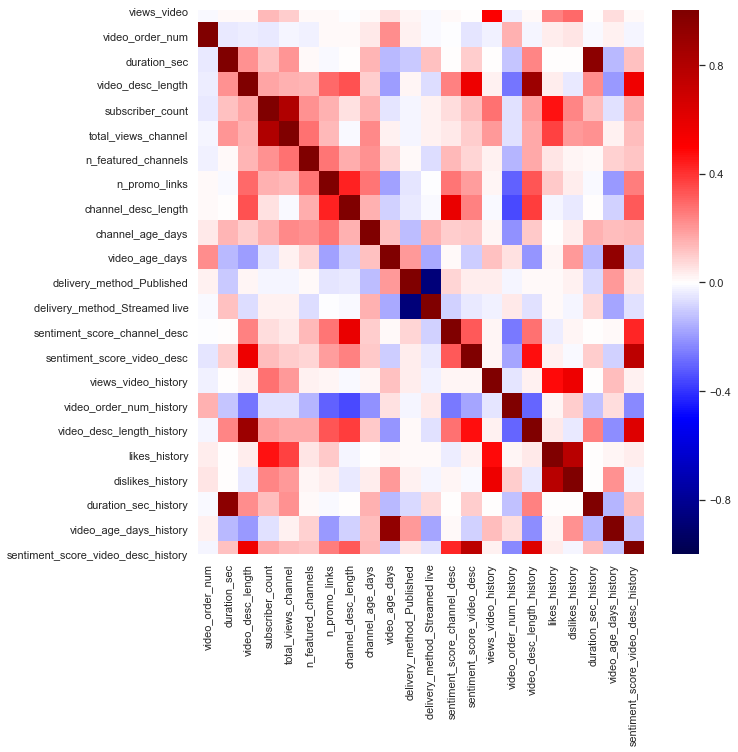

In [226]:
plt.figure(figsize=[10,10])
sns.heatmap(df_no_outliers_history_nolidisl.corr(), square=False,
            cmap="seismic", annot=False,  vmin=-1, vmax=1)
plt.gca().set_xlim(1);

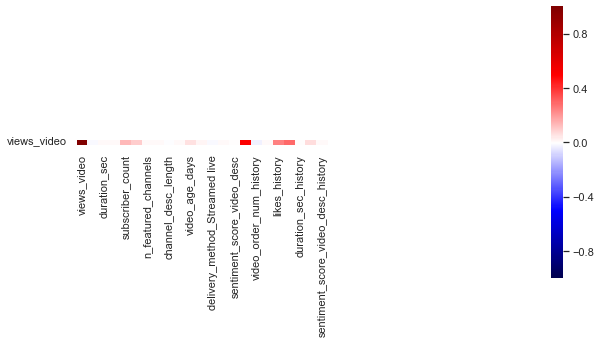

In [222]:
plt.figure(figsize=[10,10])
sns.heatmap(df_no_outliers_history_nolidisl.corr(), 
            cmap="seismic", annot=False,  vmin=-1, vmax=1, square=True, 
            cbar_kws = dict(orientation = 'vertical', shrink =0.5, pad =0.4, aspect=22))
#ax_divider
#plt.gca().set_ylim(len(df_no_outliers_history_nolidisl.corr())+0.5, -0.5);
# quick fix to make sure viz isn't cut off
plt.gca().set_ylim(1);
#plt.gca().set_xlim(1);


In [136]:
y = df_no_outliers_history['views_video']

In [137]:
pf = PolynomialFeatures(degree=2)
pf.fit(df_no_outliers_history[features_h__new_video_pred])

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [138]:
feat_array_h__new_video_pred = pf.transform(df_no_outliers_history[features_h__new_video_pred])
feat_array_h__new_video_pred = pd.DataFrame(feat_array_h__new_video_pred, columns = pf.get_feature_names(input_features=features_h__new_video_pred))

In [157]:
X_train, X_test, y_train, y_test = train_test_split(feat_array_h__new_video_pred, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)
model_w_poly_feat_h__new_video_pred = LinearRegression()
model_w_poly_feat_h__new_video_pred.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [158]:
model_w_poly_feat_h__new_video_pred.score(X_train,y_train)

0.7428630335062874

In [159]:
model_w_poly_feat_h__new_video_pred.score(X_test,y_test)

0.08224796939558876

In [160]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray
alphavec = 10**np.linspace(0,10,200)
lasso_model_w_poly_feat_h__new_video_pred = LassoCV(alphas = alphavec, cv=5)
lasso_model_w_poly_feat_h__new_video_pred.fit(X_tr, y_train);

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 896223592362.25, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1258039856815.5, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1257118571262.25, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarnin

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267433907707784.5, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298419893215567.75, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328592312344921.25, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 927795810109475.8, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 936204791067870.5, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 943810657793182.0, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292689197894703.75, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271161487589428.25, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 269782510302087.5, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 866545404023018.6, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 877131907207602.5, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 897977508066257.1, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34970306690521.0, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45605134421597.5, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39831674607218.5, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 668832907498335.8, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 682346090438372.4, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 702743449530252.1, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarn

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26198477754872.375, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34797981179910.25, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52661509048352.5, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368114656483136.75, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 386455013177788.5, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 404599222842950.6, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergence

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1409472801632.0, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2298471539358.25, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1255483038920.75, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarni

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363886414553010.5, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 392737253485580.6, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 408221081180536.5, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 923966200893960.4, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 931216030888177.2, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 937703701846850.5, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

In [161]:
lasso_model_w_poly_feat_h__new_video_pred.score(X_tr,y_train)

0.7079801920621991

In [162]:
lasso_model_w_poly_feat_h__new_video_pred.alpha_

10473.708979594508

In [163]:
lasso_model_w_poly_feat_h__new_video_pred.score(X_te,y_test)

0.10664413516059468

In [164]:
coefs = list(zip(X_train.columns, lasso_model_w_poly_feat_h__new_video_pred.coef_))

In [147]:
df_coefs = pd.DataFrame(coefs, columns=['variable', 'coefficient'])
df_coefs

,variable,coefficient
0,1,0.0
1,video_order_num,-0.0
2,duration_sec,-0.0
3,video_desc_length,-0.0
4,subscriber_count,-0.0
...,...,...
271,duration_sec_history video_age_days_history,-0.0
272,duration_sec_history sentiment_score_video_des...,-0.0
273,video_age_days_history^2,-0.0
274,video_age_days_history sentiment_score_video_d...,-0.0


In [148]:
df_coefs[df_coefs['coefficient']>0.0]

,variable,coefficient
15,views_video_history,408410.346470
37,video_order_num views_video_history,59452.432845
40,video_order_num likes_history,91418.207572
53,duration_sec video_age_days,8219.928586
58,duration_sec views_video_history,254973.030076
106,total_views_channel n_featured_channels,46672.532509
143,n_promo_links video_age_days,2237.868416
148,n_promo_links views_video_history,6561.503754
152,n_promo_links dislikes_history,18956.298320
163,channel_desc_length views_video_history,55554.654285
